In [932]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

In [933]:
df = pd.read_csv('data/Copy of Pahowdy\'s MS Database - WR.csv')

In [934]:
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header

In [935]:
df.drop(['School', 'Conference', 'NFL POS', 'Production Score', 'Combine Score', 'Efficency Score',
        'Pre-Draft', 'Post-Draft', '# of top 5  finishes', '# of top  12 finishes', '# of top  24 finishes',
         '# of top  36 finishes', '# of 1000 Rec yards seasons'], axis=1, inplace=True)

In [937]:
# drop 2020 college players
df.drop(list(range(1, 12)), inplace=True)

In [938]:
df = df.reset_index(drop=True)
df = df.set_index('Name')

In [939]:
# function to change elements to numeric
def clean(df):
    for i in df:
        if isinstance(i, str):
            var = pd.to_numeric(df[f'{i}'], errors='coerce')
            df[f'{i}'] = var
        else:
            var = pd.to_numeric(df[i], errors='coerce')
            df[i] = var
    return df

In [940]:
df = clean(df)

In [941]:
rookies_2020 = df.iloc[0:70]

In [942]:
df = df.iloc[70:]
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [943]:
df = train_set.copy()
df_test = test_set.copy()

In [944]:
corr_matrix = df.corr()
corr_matrix['AVG PPG (PPR) Season 1-3'].sort_values(ascending=False)

0
AVG PPG (PPR) Season 1-3                                                                                        1.000000
RECs 23                                                                                                         0.570457
REC Yards 23                                                                                                    0.552868
Y/TmPatt (Rec Yards Per Team Pass Attempt) 23                                                                   0.530638
PPR PPG 23                                                                                                      0.517569
                                                                                                                  ...   
DOa Diff from AVG Dominator REC Yards Touchdown MS (>=1 top 24 PPR season by position, drafted 2003-2016) 19         NaN
DOa Diff from AVG Dominator REC Yards Touchdown MS (>=1 top 24 PPR season by position, drafted 2003-2016) 20         NaN
DOa Diff from AVG Dominator RE

In [945]:
# attributes = ['AVG PPG (PPR) Season 1-3', 'RECs 23', 'REC Yards 23', 'Y/TmPatt (Rec Yards Per Team Pass Attempt) 23',
#               'PPR PPG 23']
attributes = df.columns
attributes

Index(['DR', 'DP', 'Draft Year', 'Age IN DRAFT YEAR', 'Years Played', 'G',
       'AVG PPG', 'rec', 'YARDS', 'YPR',
       ...
       'Bench', 'Verticle', 'Broad', 'Shuttle', '3 Cone', 'WaSS', 'HaSS',
       'Hand Size', 'Arm Length', 'AVG PPG (PPR) Season 1-3'],
      dtype='object', name=0, length=143)

In [946]:
# pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8))

In [947]:
labels = df['AVG PPG (PPR) Season 1-3'].fillna(0)
test_labels = df_test['AVG PPG (PPR) Season 1-3'].fillna(0)
rookies_2020_labels = rookies_2020['AVG PPG (PPR) Season 1-3'].fillna(0)

In [948]:
df.drop(['AVG PPG (PPR) Season 1-3'], axis=1, inplace=True)
df_test.drop(['AVG PPG (PPR) Season 1-3'], axis=1, inplace=True)

In [949]:
undrafted_dr = df['DR'].max()+1
undrafted_dp = df['DP'].max()+1

In [950]:
def draft_nan(df):
    df['DR'].fillna(undrafted_dr, inplace=True)
    df['DP'].fillna(undrafted_dp, inplace=True)
    return df

In [951]:
df = draft_nan(df)
df_test = draft_nan(df_test)
rookies_2020 = draft_nan(rookies_2020)

In [952]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())])
df_prepared = num_pipeline.fit_transform(df)
df_test_prepared = num_pipeline.transform(df_test)

# Linear regression

In [879]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, labels)

LinearRegression()

In [880]:
# joblib.dump(lin_reg, "wr_lin_reg.pkl")

In [881]:
predictions = lin_reg.predict(df_prepared)
lin_mse = mse(labels, predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.2684922248197386

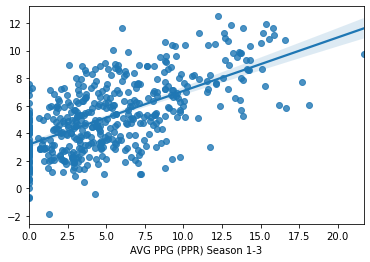

In [882]:
df = pd.DataFrame({'Actual': labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=labels,
y=predictions,
scatter=True)

In [883]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('SD:', scores.std())

In [884]:
lin_scores = cross_val_score(lin_reg, df_prepared, labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.79680359 4.77203577 3.90014558 3.75396676 4.3431335  5.17491174
 3.71229334 4.08945177 3.57572191 4.5236772 ]
Mean: 4.164214116385125
SD: 0.4981318277845135


In [885]:
r2_score(labels, predictions)

0.38870863845455883

In [886]:
predictions = lin_reg.predict(df_test_prepared)
lin_mse = mse(test_labels, predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.843790293244579

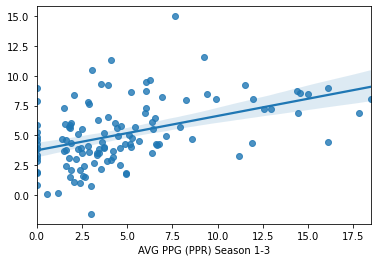

In [887]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=predictions,
scatter=True)

In [888]:
lin_scores = cross_val_score(lin_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [   8.48450582    5.88429037   16.65002138    5.16728063   10.09525056
    5.81432347    6.81205756    4.76565156   14.68508058 1237.63149217]
Mean: 131.59899540939261
SD: 368.69767802181525


In [889]:
r2_score(test_labels, predictions)

0.1448079890011622

# Decision Tree

In [890]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, labels)

DecisionTreeRegressor(random_state=42)

In [891]:
# joblib.dump(tree_reg, "wr_tree_reg.pkl")

In [892]:
predictions = tree_reg.predict(df_prepared)
tree_mse = mse(labels, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

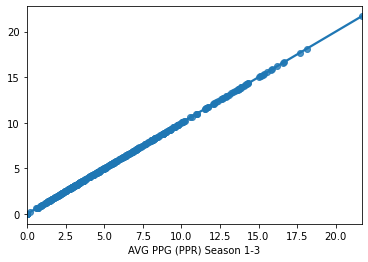

In [893]:
df = pd.DataFrame({'Actual': labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=labels,
y=predictions,
scatter=True)

In [894]:
tree_scores = cross_val_score(tree_reg, df_prepared, labels, scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [5.07548899 5.91533877 4.59594644 7.09089929 4.78609219 6.24659538
 4.96036474 5.72201255 4.91885229 5.12097662]
Mean: 5.443256725786824
SD: 0.7455030161002951


In [895]:
r2_score(labels, predictions)

1.0

In [896]:
predictions = tree_reg.predict(df_test_prepared)
tree_mse = mse(test_labels, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

5.025275164976446

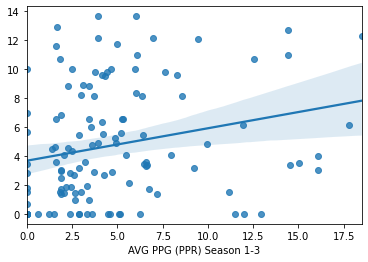

In [897]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=predictions,
scatter=True)

In [898]:
tree_scores = cross_val_score(tree_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [5.46011114 4.74292399 4.3239585  5.7239927  3.75980351 6.15776672
 3.06815528 4.52002741 6.37186197 6.11504514]
Mean: 5.024364637070431
SD: 1.0592115579273382


In [899]:
r2_score(test_labels, predictions)

-0.4617192211311072

# Random Forest

In [900]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(df_prepared, labels)

RandomForestRegressor(random_state=42)

In [901]:
# joblib.dump(forest_reg, "wr_forest_reg.pkl")

In [902]:
predictions = forest_reg.predict(df_prepared)
forest_mse = mse(labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.3738364809242756

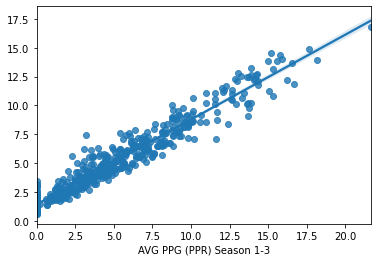

In [903]:
df = pd.DataFrame({'Actual': labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=labels,
y=predictions,
scatter=True)

In [904]:
forest_scores = cross_val_score(forest_reg, df_prepared, labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.49670996 4.4865293  3.41062917 3.76471156 3.46866749 3.75482137
 3.22444063 3.47825009 3.21311454 3.09104491]
Mean: 3.538891903083466
SD: 0.3778959708771454


In [905]:
r2_score(labels, predictions)

0.8920000796567635

In [906]:
predictions = forest_reg.predict(df_test_prepared)
forest_mse = mse(test_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.470763221823581

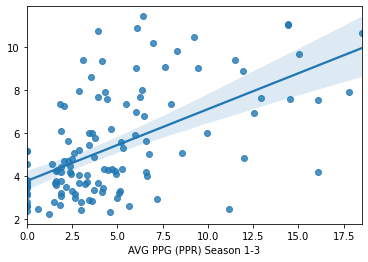

In [907]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=predictions,
scatter=True)

In [908]:
forest_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4.49156165 3.06140704 4.39645265 4.02596735 3.26635017 4.28401416
 2.11572128 3.35786819 2.46885037 4.8690524 ]
Mean: 3.6337245269493463
SD: 0.8729420560094002


In [909]:
r2_score(test_labels, predictions)

0.30274082572670236

In [910]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6], 'max_depth': [1, 2, 3, 4, 5]}]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(df_prepared, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5],
                          'max_features': [2, 4, 6],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [911]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 4, 'n_estimators': 30}

In [912]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=5, max_features=4, n_estimators=30,
                      random_state=42)

In [913]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4.041732989967386 {'max_depth': 1, 'max_features': 2, 'n_estimators': 3}
4.039686012781908 {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
3.9258555348125723 {'max_depth': 1, 'max_features': 2, 'n_estimators': 30}
4.068448663051864 {'max_depth': 1, 'max_features': 4, 'n_estimators': 3}
4.013615680279316 {'max_depth': 1, 'max_features': 4, 'n_estimators': 10}
3.890334957418303 {'max_depth': 1, 'max_features': 4, 'n_estimators': 30}
4.07165391028173 {'max_depth': 1, 'max_features': 6, 'n_estimators': 3}
3.971023788197395 {'max_depth': 1, 'max_features': 6, 'n_estimators': 10}
3.867669233109974 {'max_depth': 1, 'max_features': 6, 'n_estimators': 30}
4.017273748192735 {'max_depth': 2, 'max_features': 2, 'n_estimators': 3}
3.9234026903496355 {'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
3.8095160675653563 {'max_depth': 2, 'max_features': 2, 'n_estimators': 30}
3.9788749667893852 {'max_depth': 2, 'max_features': 4, 'n_estimators': 3}
3.819569003265279 {'max_depth': 2, 'max_

In [914]:
forest_reg = RandomForestRegressor(max_depth=3, max_features=2, n_estimators=30, random_state=42)
forest_reg.fit(df_prepared, labels)

RandomForestRegressor(max_depth=3, max_features=2, n_estimators=30,
                      random_state=42)

In [915]:
predictions = forest_reg.predict(df_prepared)
forest_mse = mse(labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.4979957330351708

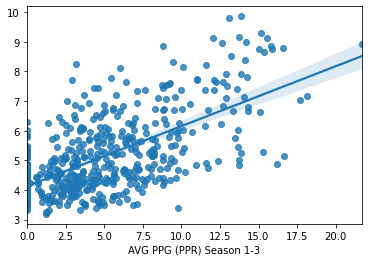

In [916]:
df = pd.DataFrame({'Actual': labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=labels,
y=predictions,
scatter=True)

In [917]:
forest_scores = cross_val_score(forest_reg, df_prepared, labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.89238659 4.80962468 3.65917002 3.60633505 3.41811201 4.15825832
 3.27881867 4.11181951 3.27440656 3.06944458]
Mean: 3.7278375993777155
SD: 0.4986131654144222


In [918]:
r2_score(labels, predictions)

0.29984870409934905

In [919]:
predictions = forest_reg.predict(df_test_prepared)
forest_mse = mse(test_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.6569765073629346

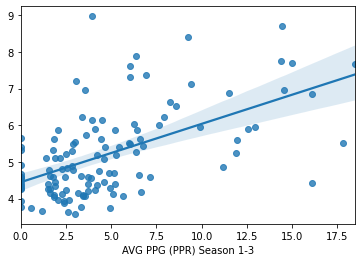

In [920]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=predictions,
scatter=True)

In [921]:
forest_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5.24884332 3.13740586 3.74161187 3.21261724 3.58707934 4.5750677
 2.62123797 3.17520548 2.73591552 4.98107067]
Mean: 3.701605499009802
SD: 0.8799379428745046


In [922]:
r2_score(test_labels, predictions)

0.22591508442235242

In [923]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [924]:
# from sklearn.base import BaseEstimator, TransformerMixin

# def indices_of_top_k(arr, k):
#     return np.sort(np.argpartition(np.array(arr), -k)[-k:])

# class TopFeatureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, feature_importances, k):
#         self.feature_importances = feature_importances
#         self.k = k
#     def fit(self, X, y=None):
#         self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
#         return self
#     def transform(self, X):
#         return X[:, self.feature_indices_]

In [957]:
# k = 10

In [958]:
# top_k_feature_indices = indices_of_top_k(feature_importances, k)
# top_k_feature_indices

array([ 0,  1,  6, 16, 18, 22, 43, 44, 56, 66])

In [959]:
# np.array(attributes)[top_k_feature_indices]

array(['DR', 'DP', 'AVG PPG', 'Decimal BOA (30%)', 'RecYds/TmPatt Best',
       'RecYds/TmPatt Above Team AVG Best',
       'Last S/EX (Yds Share Over Expectation)',
       'TeamMate Score (TeamMate Over Expected)', 'PPR PPG 23',
       'REC Yards 21'], dtype=object)

In [963]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.10378812845536603, 'DR'),
 (0.06290653293932641, 'DP'),
 (0.03636237292258208, 'RecYds/TmPatt Best'),
 (0.031004202715639178, 'Decimal BOA (30%)'),
 (0.030060602928404113, 'AVG PPG'),
 (0.027196062901852454, 'TeamMate Score (TeamMate Over Expected)'),
 (0.026428058669775004, 'Last S/EX (Yds Share Over Expectation)'),
 (0.02593634827894499, 'PPR PPG 23'),
 (0.02545597480209821, 'RecYds/TmPatt Above Team AVG Best'),
 (0.0229411221715067, 'REC Yards 21'),
 (0.022808265324218584, 'RecYds/TmPatt First'),
 (0.02177256488279938, 'YOa (Yards Over Age Average) First'),
 (0.021514778556274646, 'RecYds/TmPatt Above Team AVG Last'),
 (0.020689474957072088, 'YARDS'),
 (0.020326965477364612, 'REC TDs 21'),
 (0.019732851679397746, 'MS RECs 18'),
 (0.018670349763149914, 'RECs 22'),
 (0.017739120090727936, 'REC Yards 23'),
 (0.017466486650991205, 'RecYds/TmPatt Above Team AVG First'),
 (0.01630858114509837, 'Games Played 22'),
 (0.01608587229297816, 'DOa (Dom Over Average) AVG'),
 (0.01433930695145

# feature importances

In [849]:
forest_reg = RandomForestRegressor(max_depth=3, max_features=2, n_estimators=30, random_state=42)
forest_reg.fit(df_prepared, labels)

RandomForestRegressor(max_depth=3, max_features=2, n_estimators=30,
                      random_state=42)

In [850]:
predictions = forest_reg.predict(df_prepared)
forest_mse = mse(labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.327761636146162

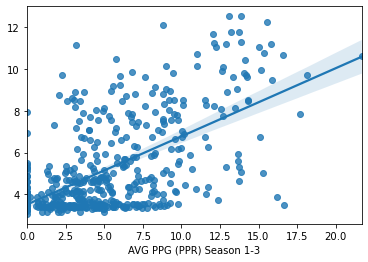

In [851]:
df = pd.DataFrame({'Actual': labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=labels,
y=predictions,
scatter=True)

In [852]:
forest_scores = cross_val_score(forest_reg, df_prepared, labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.78993104 4.46410901 3.29179401 3.7816477  3.35301319 3.87135132
 3.19901071 3.61671131 3.28658277 3.04438436]
Mean: 3.5698535421411144
SD: 0.4005373543154016


In [853]:
r2_score(labels, predictions)

0.36633784843459005

In [854]:
predictions = forest_reg.predict(df_test_prepared)
forest_mse = mse(test_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.3998630387298148

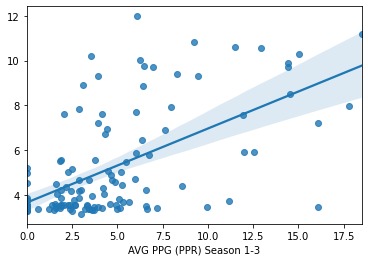

In [855]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=predictions,
scatter=True)

In [856]:
forest_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.77806814 2.81918946 3.97483139 2.49869475 2.74907668 4.01015832
 2.44309943 3.46802596 2.6866686  5.11457483]
Mean: 3.3542387564834457
SD: 0.8226181912911023


In [857]:
r2_score(test_labels, predictions)

0.3309368545218764